# Partial History



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import json
from scipy import stats
import matplotlib.lines as lines

sys.path.insert(1, "../utils/")
import HH, Stimuli

from neuron import h
h.load_file("stdrun.hoc")
from neuron.units import mV, ms

## load data

In [6]:
data_dir = '../data/partial_history/'
data_dir_wb = '../data/partial_history_WB/'
figures_dir = '../figures/'

In [7]:
with open(f'{data_dir}stimuli.json') as f:
    stimuli = json.load(f)

In [9]:
histories_sets = {
    'base': np.load(f'{data_dir}histories_base.npy'),
    'lw': np.load(f'{data_dir}histories_lw.npy'),
    'lt': np.load(f'{data_dir}histories_lt.npy'),
    'lwlt': np.load(f'{data_dir}histories_lwlt.npy'),
    'burst': np.load(f'{data_dir}histories_burst.npy'),
    'wb':np.load(f'{data_dir_wb}histories_wb.npy')
}

In [11]:
results_files = os.listdir(f'{data_dir}results')
print(f'number of results files: {len(results_files)} / {5*28*1000}')

results = {
    'base':{n:{} for n in range(3,31)},
    'lw':{n:{} for n in range(3,31)},
    'lt':{n:{} for n in range(3,31)},
    'lwlt':{n:{} for n in range(3,31)},
    'burst':{n:{} for n in range(3,31)},
    'wb':{n:{} for n in range(3,31)},
}

progress = 0.0
print('______PROGRESS______')
for i, results_file in enumerate(results_files):
    stim_type = results_file.split('_')[0]
    n = int(results_file.split('_')[1])
    pattern_id = int(results_file.split('_')[2].strip('.npy'))
    
    results[stim_type][n][pattern_id] = np.load(f'{data_dir}results/{results_file}')
    
    if i / len(results_files) > progress:
        progress += 0.05
        print('=', end='')
print()

progress = 0.0
print('______PROGRESS______')
for i, results_file in enumerate(os.listdir(f'{data_dir_wb}results')):
    stim_type = results_file.split('_')[0]
    n = int(results_file.split('_')[1])
    pattern_id = int(results_file.split('_')[2].strip('.npy'))
    
    results[stim_type][n][pattern_id] = np.load(f'{data_dir_wb}results/{results_file}')
    
    if i / len(len(os.listdir(f'{data_dir_wb}results'))) > progress:
        progress += 0.05
        print('=', end='')

number of results files: 140000 / 140000
______PROGRESS______
______PROGRESS______
====

In [13]:
def calc_spike_presence_prediction_acc(df):
    no_spike = np.sum(np.isnan(df))
    spike = df.shape[0] - no_spike
    return (no_spike/df.shape[0])**2 + (spike/df.shape[0])**2

def calc_nst_std(df):
    return np.std(df[~np.isnan(df)])

def calc_nst_mae(df):
    _df = df[~np.isnan(df)]
    return np.nanmean(np.abs(_df - np.mean(_df)))

In [70]:
spike_presence_prediction_accs = {
    'base': {n:[] for n in range(3,31)},
    'lw': {n:[] for n in range(3,31)},
    'lt': {n:[] for n in range(3,31)},
    'lwlt': {n:[] for n in range(3,31)},
    'burst': {n:[] for n in range(3,31)},
    'wb': {n:[] for n in range(3,31)}
}
nst_stds = {
    'base': {n:[] for n in range(3,31)},
    'lw': {n:[] for n in range(3,31)},
    'lt': {n:[] for n in range(3,31)},
    'lwlt': {n:[] for n in range(3,31)},
    'burst': {n:[] for n in range(3,31)},
    'wb': {n:[] for n in range(3,31)},
}
nst_maes = {
    'base': {n:[] for n in range(3,31)},
    'lw': {n:[] for n in range(3,31)},
    'lt': {n:[] for n in range(3,31)},
    'lwlt': {n:[] for n in range(3,31)},
    'burst': {n:[] for n in range(3,31)},
    'wb': {n:[] for n in range(3,31)},
}

for stim_type in results:
    for n in range(3,31):
        for pattern_ind in range(1000):
            try:
                df = results[stim_type][n][pattern_ind]
                spike_presence_prediction_accs[stim_type][n].append(calc_spike_presence_prediction_acc(df))
                nst_stds[stim_type][n].append(calc_nst_std(df))
                nst_maes[stim_type][n].append(calc_nst_mae(df))
            except:
                pass

/home/ec753/venvs/jupyter_env/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ec753/venvs/jupyter_env/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/ec753/venvs/jupyter_env/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ec753/venvs/jupyter_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ec753/venvs/jupyter_env/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_10411/1350620721.py:11: Runtim

In [190]:
# do the same thing but with a threshold cutoff for the nsts
etimes = Stimuli.poisson_process_duration(5, 1000000)
itimes = Stimuli.poisson_process_duration(15, 1000000)
alltimes = sorted(etimes + itimes)
stim_intervals = sorted(np.diff(alltimes))

nst_threshold = stim_intervals[int(.95*len(stim_intervals))]

spike_presence_prediction_accs_subthresh = {
    'base': {n:[] for n in range(3,31)},
    'lw': {n:[] for n in range(3,31)},
    'lt': {n:[] for n in range(3,31)},
    'lwlt': {n:[] for n in range(3,31)},
    'burst': {n:[] for n in range(3,31)},
    'wb': {n:[] for n in range(3,31)}
}
nst_stds_subthresh = {
    'base': {n:[] for n in range(3,31)},
    'lw': {n:[] for n in range(3,31)},
    'lt': {n:[] for n in range(3,31)},
    'lwlt': {n:[] for n in range(3,31)},
    'burst': {n:[] for n in range(3,31)},
    'wb': {n:[] for n in range(3,31)},
}
nst_maes_subthresh = {
    'base': {n:[] for n in range(3,31)},
    'lw': {n:[] for n in range(3,31)},
    'lt': {n:[] for n in range(3,31)},
    'lwlt': {n:[] for n in range(3,31)},
    'burst': {n:[] for n in range(3,31)},
    'wb': {n:[] for n in range(3,31)},
}

for stim_type in results:
    for n in range(3,31):
        for pattern_ind in range(1000):
            try:
                df = results[stim_type][n][pattern_ind]
                no_spike = np.sum(np.isnan(df))
                df = df[df < nst_threshold]
                spike = df.shape[0]
                
                spike_presence_prediction_accs_subthresh[stim_type][n].append(
                    (no_spike/(no_spike+spike))**2 + (spike/(no_spike+spike))**2)
                nst_stds_subthresh[stim_type][n].append(calc_nst_std(df))
                nst_maes_subthresh[stim_type][n].append(calc_nst_mae(df))
            except:
                pass

/home/ec753/venvs/jupyter_env/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ec753/venvs/jupyter_env/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/ec753/venvs/jupyter_env/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ec753/venvs/jupyter_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ec753/venvs/jupyter_env/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_10411/1350620721.py:11: Runtim

In [191]:
stim_type = 'wb'
n = 19
pattern_int = 8
df = results[stim_type][n][pattern_ind]

print(f'{calc_spike_presence_prediction_acc(df)}')
print(f'thresh {calc_spike_presence_prediction_acc_subthresh(df, 5)}')

0.9900500000000001
thresh 0.9940060481684814


In [192]:
spike_presence_prediction_acc_means = {
    'base': [],
    'lw': [],
    'lt': [],
    'lwlt': [],
    'burst': [],
    'wb': []
}
nst_std_means = {
    'base': [],
    'lw': [],
    'lt': [],
    'lwlt': [],
    'burst': [],
    'wb': []
}
nst_mae_means = {
    'base': [],
    'lw': [],
    'lt': [],
    'lwlt': [],
    'burst': [],
    'wb': []
}

for stim_type in spike_presence_prediction_accs:
    for n in range(3,31):
        spike_presence_prediction_acc_means[stim_type].append(np.mean(spike_presence_prediction_accs[stim_type][n]))
        
        nst_std_means[stim_type].append(np.nanmean(nst_stds[stim_type][n]))
        
        nst_mae_means[stim_type].append(np.nanmean(nst_maes[stim_type][n]))

In [193]:
spike_presence_prediction_acc_means_subthresh = {
    'base': [],
    'lw': [],
    'lt': [],
    'lwlt': [],
    'burst': [],
    'wb': []
}
nst_std_means_subthresh = {
    'base': [],
    'lw': [],
    'lt': [],
    'lwlt': [],
    'burst': [],
    'wb': []
}
nst_mae_means_subthresh = {
    'base': [],
    'lw': [],
    'lt': [],
    'lwlt': [],
    'burst': [],
    'wb': []
}

for stim_type in spike_presence_prediction_accs_subthresh:
    for n in range(3,31):
        spike_presence_prediction_acc_means_subthresh[stim_type].append(
            np.nanmean(spike_presence_prediction_accs_subthresh[stim_type][n]))
        
        nst_std_means_subthresh[stim_type].append(np.nanmean(nst_stds_subthresh[stim_type][n]))
        
        nst_mae_means_subthresh[stim_type].append(np.nanmean(nst_maes_subthresh[stim_type][n]))

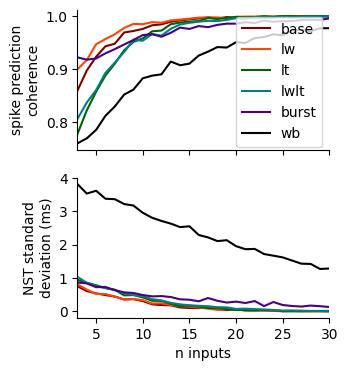

In [194]:
colors = {
    'base': 'maroon',
    'lw': 'orangered',
    'lt': 'darkgreen',
    'lwlt': 'teal',
    'burst': 'indigo',
    'wb':'black'
}
ns = np.arange(3,31,1)

fig, axes = plt.subplots(2,1, figsize=(3.25,4), sharex=True)
for stim_type in spike_presence_prediction_acc_means:
    axes[0].plot(ns, spike_presence_prediction_acc_means[stim_type], c=colors[stim_type])
    
    axes[1].plot(ns, nst_std_means[stim_type], c=colors[stim_type])

axes[-1].set_xlim(3,30)

axes[0].set_ylabel('spike prediction\ncoherence')
axes[1].set_ylabel('NST standard\ndeviation (ms)')
axes[1].set_xlabel('n inputs')
axes[0].legend(list(colors.keys()))

axes[0].spines['top'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[1].spines['right'].set_visible(False)

savefig = False
if savefig:
    plt.savefig(f'{figures_dir}spike_prediction_and_nst_std.svg', format='svg')
    #plt.savefig(f'{figures_dir}spike_prediction_and_nst_std.png', format='png', dpi=300)

plt.show()

In [195]:
spike_rates = {
    'base': {n:[] for n in range(3,31)},
    'lw': {n:[] for n in range(3,31)},
    'lt': {n:[] for n in range(3,31)},
    'lwlt': {n:[] for n in range(3,31)},
    'burst': {n:[] for n in range(3,31)},
    'wb': {n:[] for n in range(3,31)}
}
nsts = {
    'base': [],
    'lw': [],
    'lt': [],
    'lwlt': [],
    'burst': [],
    'wb': []
}
for stim_type in results:
    for n in ns:
        for pattern_ind in results['base'][n]:
            _nsts = list(results[stim_type][n][pattern_ind][~np.isnan(results[stim_type][n][pattern_ind])])
            nsts[stim_type].extend(_nsts)
            spike_rates[stim_type][n].append(len(_nsts)/1000)

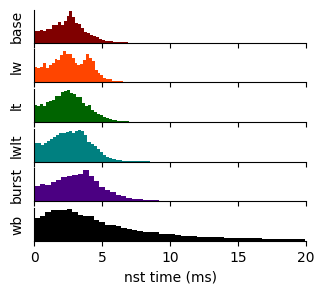

In [212]:
fig, axes = plt.subplots(len(nsts), 1, sharex=True, figsize=(3.5,3))

for i, stim_type in enumerate(nsts):
    axes[i].hist(nsts[stim_type], bins = 50, color=colors[stim_type])
    axes[i].set_yticks([])
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].set_ylabel(stim_type)
axes[-1].set_xlim(0, 20)
axes[-1].set_xlabel('nst time (ms)')
plt.show()

In [206]:
avg_nsts = {}
for stim_type in results:
    avg_nsts[stim_type] = np.nanmean(nsts[stim_type])

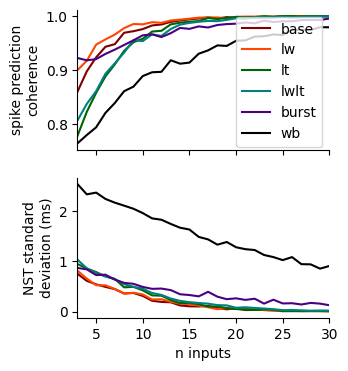

In [196]:
colors = {
    'base': 'maroon',
    'lw': 'orangered',
    'lt': 'darkgreen',
    'lwlt': 'teal',
    'burst': 'indigo',
    'wb':'black'
}
ns = np.arange(3,31,1)

fig, axes = plt.subplots(2,1, figsize=(3.25,4), sharex=True)
for stim_type in spike_presence_prediction_acc_means_subthresh:
    axes[0].plot(ns, spike_presence_prediction_acc_means_subthresh[stim_type], c=colors[stim_type])
    
    axes[1].plot(ns, nst_std_means_subthresh[stim_type], c=colors[stim_type])

axes[-1].set_xlim(3,30)

axes[0].set_ylabel('spike prediction\ncoherence')
axes[1].set_ylabel('NST standard\ndeviation (ms)')
axes[1].set_xlabel('n inputs')
axes[0].legend(list(colors.keys()))

axes[0].spines['top'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[1].spines['right'].set_visible(False)

savefig = False
if savefig:
    plt.savefig(f'{figures_dir}spike_prediction_and_nst_std.svg', format='svg')
    #plt.savefig(f'{figures_dir}spike_prediction_and_nst_std.png', format='png', dpi=300)

plt.show()

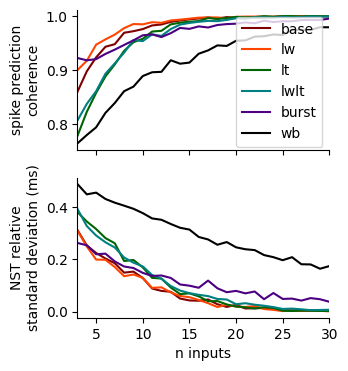

In [211]:
colors = {
    'base': 'maroon',
    'lw': 'orangered',
    'lt': 'darkgreen',
    'lwlt': 'teal',
    'burst': 'indigo',
    'wb':'black'
}
ns = np.arange(3,31,1)

fig, axes = plt.subplots(2,1, figsize=(3.25,4), sharex=True)
for stim_type in spike_presence_prediction_acc_means_subthresh:
    axes[0].plot(ns, spike_presence_prediction_acc_means_subthresh[stim_type], c=colors[stim_type])
    
    axes[1].plot(ns, nst_std_means_subthresh[stim_type] / avg_nsts[stim_type], c=colors[stim_type])

axes[-1].set_xlim(3,30)

axes[0].set_ylabel('spike prediction\ncoherence')
axes[1].set_ylabel('NST relative\nstandard deviation (ms)')
axes[1].set_xlabel('n inputs')
axes[0].legend(list(colors.keys()))

axes[0].spines['top'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[1].spines['right'].set_visible(False)

savefig = False
if savefig:
    plt.savefig(f'{figures_dir}spike_prediction_and_nst_std.svg', format='svg')
    #plt.savefig(f'{figures_dir}spike_prediction_and_nst_std.png', format='png', dpi=300)

plt.show()

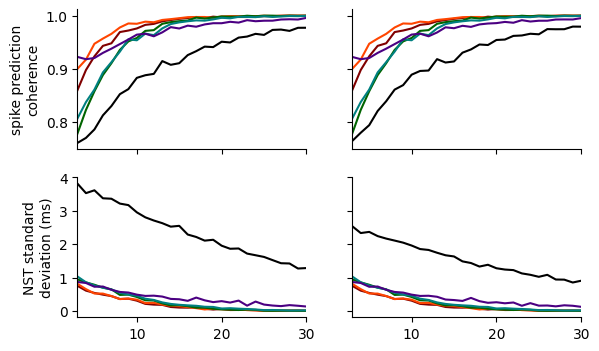

In [197]:
colors = {
    'base': 'maroon',
    'lw': 'orangered',
    'lt': 'darkgreen',
    'lwlt': 'teal',
    'burst': 'indigo',
    'wb':'black'
}
ns = np.arange(3,31,1)

fig, axes = plt.subplots(2,2, figsize=(6.5,4), sharex=True, sharey='row')
for stim_type in spike_presence_prediction_acc_means:
    # all values
    axes[0,0].plot(ns, spike_presence_prediction_acc_means[stim_type], c=colors[stim_type])
    axes[1,0].plot(ns, nst_std_means[stim_type], c=colors[stim_type])
    
    # sub nst threshold values
    axes[0,1].plot(ns, spike_presence_prediction_acc_means_subthresh[stim_type], c=colors[stim_type])
    axes[1,1].plot(ns, nst_std_means_subthresh[stim_type], c=colors[stim_type])


axes[0,0].set_xlim(3,30)

axes[0,0].set_ylabel('spike prediction\ncoherence')
axes[1,0].set_ylabel('NST standard\ndeviation (ms)')


axes[0,0].spines['top'].set_visible(False)
axes[0,0].spines['right'].set_visible(False)
axes[0,1].spines['top'].set_visible(False)
axes[0,1].spines['right'].set_visible(False)
axes[1,0].spines['top'].set_visible(False)
axes[1,0].spines['right'].set_visible(False)
axes[1,1].spines['top'].set_visible(False)
axes[1,1].spines['right'].set_visible(False)


savefig = False
if savefig:
    plt.savefig(f'{figures_dir}spike_prediction_and_nst_std.svg', format='svg')
    #plt.savefig(f'{figures_dir}spike_prediction_and_nst_std.png', format='png', dpi=300)

plt.show()

In [201]:
nst_std_means_subthresh['wb'][-1]

0.9064203576005326

In [202]:
nst_std_means['wb'][-1]

1.2852131645555795